In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 11.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.1-cp311-cp311-linux_x86_64.whl size=660712 sha256=bbedc05b7ab5963873ac947b41e9d40aba99319da8f64ca69fa07aa0d64d3bbe
  Stored in directory: /root/.cache/pip/wheels/49/0a/64/6530a5fde64f984ebb4992e38744fdfd2a61f510377b3a24d9
Successfully built pycuda


In [ ]:
import numpy as np
from time import time

def conv2d_sequential(image, kernel):
    hi, wi = image.shape
    hk, wk = kernel.shape
    output = np.zeros((hi - hk + 1, wi - wk + 1))

    for i in range(hi - hk + 1):
        for j in range(wi - wk + 1):
            output[i,j] = np.sum(image[i:i+hk, j:j+wk] * kernel)

    return output

In [ ]:
from threading import Thread
import numpy as np

def conv2d_threaded(image, kernel, num_threads=2):
    hi, wi = image.shape
    hk, wk = kernel.shape
    output = np.zeros((hi - hk + 1, wi - wk + 1))
    chunk_size = (hi - hk + 1) // num_threads

    def worker(start_row, end_row):
        for i in range(start_row, end_row):
            for j in range(wi - wk + 1):
                output[i,j] = np.sum(image[i:i+hk, j:j+wk] * kernel)

    threads = []
    for t in range(num_threads):
        start = t * chunk_size
        end = (t + 1) * chunk_size if t != num_threads - 1 else (hi - hk + 1)
        thread = Thread(target=worker, args=(start, end))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    return output

In [ ]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import numpy as np

# CUDA kernel for 2D convolution
conv_kernel_code = """
__global__ void conv2d(float *output, const float *image, const float *kernel,
                       int image_width, int image_height,
                       int kernel_width, int kernel_height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < image_width - kernel_width + 1 && y < image_height - kernel_height + 1)
    {
        float sum = 0.0f;
        for (int ky = 0; ky < kernel_height; ky++)
        {
            for (int kx = 0; kx < kernel_width; kx++)
            {
                sum += image[(y + ky) * image_width + (x + kx)] *
                       kernel[ky * kernel_width + kx];
            }
        }
        output[y * (image_width - kernel_width + 1) + x] = sum;
    }
}
"""

def conv2d_pycuda(image, kernel):
    # Compile the CUDA kernel
    mod = SourceModule(conv_kernel_code)
    conv2d_gpu = mod.get_function("conv2d")

    # Convert inputs to float32
    image = image.astype(np.float32)
    kernel = kernel.astype(np.float32)

    # Get dimensions
    hi, wi = image.shape
    hk, wk = kernel.shape

    # Allocate GPU memory
    image_gpu = cuda.mem_alloc(image.nbytes)
    kernel_gpu = cuda.mem_alloc(kernel.nbytes)
    output_gpu = cuda.mem_alloc((hi - hk + 1) * (wi - wk + 1) * 4)  # float32 = 4 bytes

    # Copy data to GPU
    cuda.memcpy_htod(image_gpu, image)
    cuda.memcpy_htod(kernel_gpu, kernel)

    # Define block and grid dimensions
    block_size = (16, 16, 1)
    grid_x = (wi - wk + 1 + block_size[0] - 1) // block_size[0]
    grid_y = (hi - hk + 1 + block_size[1] - 1) // block_size[1]
    grid_size = (grid_x, grid_y)

    # Execute kernel
    conv2d_gpu(output_gpu, image_gpu, kernel_gpu,
               np.int32(wi), np.int32(hi),
               np.int32(wk), np.int32(hk),
               block=block_size, grid=grid_size)

    # Copy result back to host
    output = np.empty((hi - hk + 1, wi - wk + 1), dtype=np.float32)
    cuda.memcpy_dtoh(output, output_gpu)

    return output

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

def compare_performance(image_size=(1024, 1024), kernel_size=(3, 3)):
    # Generate random image and kernel
    image = np.random.rand(*image_size).astype(np.float32)
    kernel = np.random.rand(*kernel_size).astype(np.float32)

    # Test sequential
    start = time()
    output_seq = conv2d_sequential(image, kernel)
    seq_time = time() - start

    # Test threaded (try different thread counts)
    thread_counts = [1,2]
    thread_times = []
    for n in thread_counts:
        start = time()
        output_thread = conv2d_threaded(image, kernel, n)
        thread_times.append(time() - start)

    # Test GPU
    start = time()
    output_gpu = conv2d_pycuda(image, kernel)
    gpu_time = time() - start

    # Verify all outputs are approximately equal (float precision differences)
    assert np.allclose(output_seq, output_thread, atol=1e-5)
    assert np.allclose(output_seq, output_gpu, atol=1e-5)

    # Calculate speedups
    speedup_thread = [seq_time / t for t in thread_times]
    speedup_gpu = seq_time / gpu_time

    # Calculate efficiency
    efficiency_thread = [s / n for s, n in zip(speedup_thread, thread_counts)]

    # Visualization
    plt.figure(figsize=(15, 5))

    # Execution time plot
    plt.subplot(1, 3, 1)
    plt.bar(['Sequential'] + [f'Threads {n}' for n in thread_counts] + ['PyCUDA GPU'],
            [seq_time] + thread_times + [gpu_time])
    plt.title('Execution Time')
    plt.ylabel('Seconds (log scale)')
    plt.yscale('log')

    # Speedup plot
    plt.subplot(1, 3, 2)
    plt.bar([f'Threads {n}' for n in thread_counts] + ['PyCUDA GPU'],
            speedup_thread + [speedup_gpu])
    plt.title('Speedup (vs Sequential)')
    plt.ylabel('Speedup')

    # Efficiency plot
    plt.subplot(1, 3, 3)
    plt.bar([f'Threads {n}' for n in thread_counts], efficiency_thread)
    plt.title('Threading Efficiency')
    plt.ylabel('Efficiency (speedup/threads)')
    plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

    return {
        'sequential_time': seq_time,
        'threaded_times': dict(zip(thread_counts, thread_times)),
        'gpu_time': gpu_time,
        'speedup_thread': dict(zip(thread_counts, speedup_thread)),
        'speedup_gpu': speedup_gpu,
        'efficiency_thread': dict(zip(thread_counts, efficiency_thread))
    }

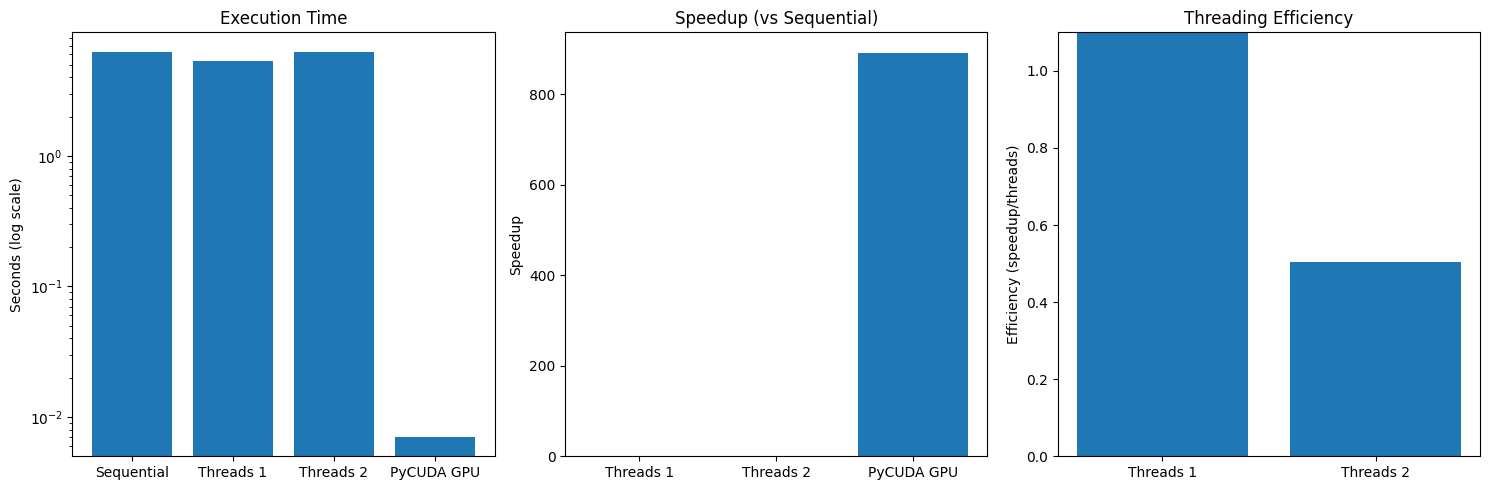

,sequential_time,threaded_times,gpu_time,speedup_thread,speedup_gpu,efficiency_thread
1,6.285998,5.318147,0.007041,1.181990,892.803766,1.181990
2,6.285998,6.238360,0.007041,1.007636,892.803766,0.503818


In [ ]:
results=compare_performance()
import pandas as pd
data=pd.DataFrame(results)
data